# Modelling

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os

In [4]:
train_loader = torch.load('../data/processed/dataset/train_loader.pth', weights_only=False)
test_loader = torch.load('../data/processed/dataset/test_loader.pth', weights_only=False)
val_loader = torch.load('../data/processed/dataset/val_loader.pth', weights_only=False)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(labels)  
    break

torch.Size([32, 3, 100, 100])
tensor([1, 1, 3, 1, 3, 3, 2, 1, 2, 2, 2, 3, 2, 1, 1, 0, 1, 2, 2, 1, 3, 0, 3, 1,
        2, 2, 1, 2, 2, 3, 0, 1])


In [7]:
device="mps"
class_mapping = {'indian_market': 0, 'onion': 1, 'potato': 2, 'tomato': 3}
class_names = [name for name, idx in sorted(class_mapping.items(), key=lambda x: x[1])]

In [ ]:
class Trainer():
    def __init__(self, model, optimizer, criterion, scheduler, checkpoint_path='best_model.pth', patience=3, log_dir='runs'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.checkpoint_path = checkpoint_path
        self.patience = patience
        self.best_val_loss = np.inf
        self.early_stop_counter = 0
        self.all_train_loss = []
        self.all_train_accuracy = []
        self.all_val_loss = []
        self.all_val_accuracy = []
        self.writer = SummaryWriter(log_dir=log_dir)

    def train(self, train_loader, val_loader, num_epochs=20):        
        for epoch in range(num_epochs):  
            self.model.train()
            correct = 0
            total = 0
            train_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()  
                outputs = self.model(images)  
                loss = self.criterion(outputs, labels)  
                loss.backward() 
                train_loss += loss.item()
                self.optimizer.step()
                predicted = torch.argmax(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_accuracy = 100 * correct / total
            train_loss /= len(train_loader)
            self.all_train_loss.append(train_loss)
            self.all_train_accuracy.append(train_accuracy)

            val_loss, val_accuracy = self.validate(val_loader)

            self.all_val_loss.append(val_loss)
            self.all_val_accuracy.append(val_accuracy)

            self.writer.add_scalar('Loss/Train', train_loss, epoch)
            self.writer.add_scalar('Loss/Validation', val_loss, epoch)
            self.writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
            self.writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), self.checkpoint_path)
                self.early_stop_counter = 0
            else:
                self.early_stop_counter += 1

            print(f'Epoch [{epoch + 1}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

            if self.early_stop_counter >= self.patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break

            self.scheduler.step()

        self.writer.close()

    def validate(self, val_loader):
        self.model.eval()
        correct = 0
        total = 0
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                val_loss += self.criterion(outputs, labels).item()
                predicted = torch.argmax(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_loss /= len(val_loader)
        return val_loss, val_accuracy

    def test(self, test_loader):
        self.model.load_state_dict(torch.load(self.checkpoint_path))
        self.model.eval()
        correct = 0
        total = 0
        test_loss = 0
        real_labels = []
        predicted_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                test_loss += self.criterion(outputs, labels).item()
                predicted = torch.argmax(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                real_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        test_accuracy = 100 * correct / total
        test_loss /= len(test_loader)

        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        return real_labels, predicted_labels

    def plot_metrics(self):
        epochs = np.arange(1, len(self.all_train_loss) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.all_train_loss, label='Train Loss')
        plt.plot(epochs, self.all_val_loss, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.all_train_accuracy, label='Train Accuracy')
        plt.plot(epochs, self.all_val_accuracy, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
    

## Simple CNN

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4, img_size=100):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # img_size // 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * (img_size // 4) * (img_size // 4), num_classes) 

    def forward(self, x):
        x=self.conv1(x)
        x=F.relu(x)
        x = self.pool(x)
        x=self.conv2(x)
        x=F.relu(x)
        x = self.pool(x)
        # print(x.shape)  # Shape: [32, 32, img_size // 4, img_size // 4]
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    

model = SimpleCNN(num_classes=4, img_size=100)
model.to(device) 
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [17]:
trainer = Trainer(model, optimizer, criterion, scheduler, checkpoint_path='../models/simple_cnn.pth', patience=3)
trainer.train(train_loader, val_loader, num_epochs=20)

Epoch [1], Train Loss: 0.7859, Train Accuracy: 66.95%, Val Loss: 0.5495, Val Accuracy: 77.56%
Epoch [2], Train Loss: 0.5639, Train Accuracy: 78.10%, Val Loss: 0.5464, Val Accuracy: 78.04%
Epoch [3], Train Loss: 0.4984, Train Accuracy: 80.84%, Val Loss: 0.4623, Val Accuracy: 81.89%
Epoch [4], Train Loss: 0.4450, Train Accuracy: 82.84%, Val Loss: 0.4891, Val Accuracy: 81.89%
Epoch [5], Train Loss: 0.4174, Train Accuracy: 83.55%, Val Loss: 0.4818, Val Accuracy: 81.41%
Epoch [6], Train Loss: 0.3714, Train Accuracy: 85.58%, Val Loss: 0.3962, Val Accuracy: 85.42%
Epoch [7], Train Loss: 0.3487, Train Accuracy: 86.42%, Val Loss: 0.3897, Val Accuracy: 86.06%
Epoch [8], Train Loss: 0.3439, Train Accuracy: 86.54%, Val Loss: 0.3878, Val Accuracy: 86.54%
Epoch [9], Train Loss: 0.3411, Train Accuracy: 86.98%, Val Loss: 0.3762, Val Accuracy: 85.26%
Epoch [10], Train Loss: 0.3449, Train Accuracy: 87.06%, Val Loss: 0.3721, Val Accuracy: 86.22%
Epoch [11], Train Loss: 0.3331, Train Accuracy: 86.54%, Val

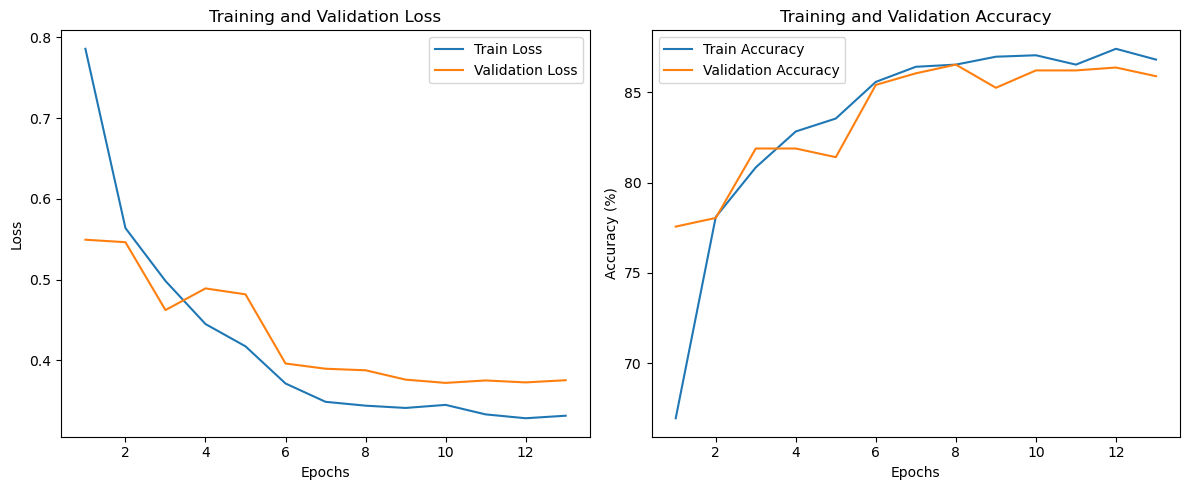

In [18]:
trainer.plot_metrics()

**Inference on Test Data**

In [19]:
real_labels, predicted_labels = trainer.test(test_loader)

Test Loss: 0.4810, Test Accuracy: 80.34%


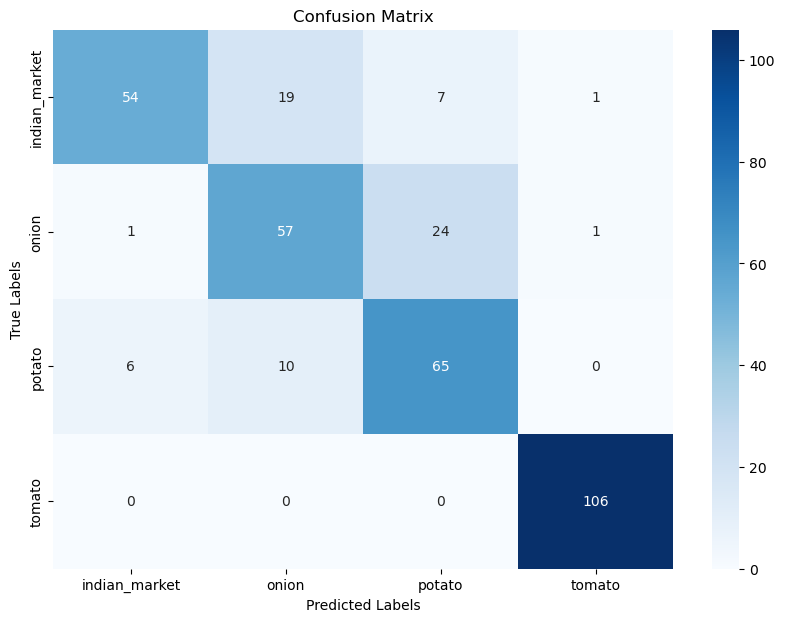

In [20]:
plt.figure(figsize=(10, 7))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(real_labels, predicted_labels),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plots, we can see that a simple CNN model with 2 convolution layers is able to learn the features of the images and classify them with a good accuracy of 80.34% on the test set.
- However, Onion and Potato are confused with each other and the model is not able to classify them correctly. 
- Further tuning of the model parameters may help improve the classification accuracy for these classes.

## Complex CNN

In [22]:
class ComplexCNN(nn.Module):
    def __init__(self, num_classes=4, img_size=100):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # img_size // 2

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * (img_size // 16) * (img_size // 16), 1024) 
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x=self.conv1(x)
        x = self.batch_norm1(x)
        x=F.relu(x)
        x = self.pool(x)

        x=self.conv2(x)
        x = self.batch_norm2(x)
        x=F.relu(x)
        x = self.pool(x)

        x=self.conv3(x)
        x = self.batch_norm3(x)
        x=F.relu(x)
        x = self.pool(x)

        x=self.conv4(x)
        x = self.batch_norm4(x)
        x=F.relu(x)
        x = self.pool(x)

        # print(x.shape) 
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        
        x = F.relu(x)
        x = self.fc2(x)
        return x
    

model = ComplexCNN(num_classes=4, img_size=100)
model.to(device) 
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [23]:
trainer = Trainer(model, optimizer, criterion, scheduler, checkpoint_path='../models/complex_cnn.pth', patience=3)
trainer.train(train_loader, val_loader, num_epochs=20)

Epoch [1], Train Loss: 1.1100, Train Accuracy: 66.51%, Val Loss: 0.9014, Val Accuracy: 69.71%
Epoch [2], Train Loss: 0.5453, Train Accuracy: 78.73%, Val Loss: 0.5019, Val Accuracy: 79.81%
Epoch [3], Train Loss: 0.4471, Train Accuracy: 82.99%, Val Loss: 0.3920, Val Accuracy: 85.26%
Epoch [4], Train Loss: 0.4109, Train Accuracy: 83.63%, Val Loss: 0.4036, Val Accuracy: 82.69%
Epoch [5], Train Loss: 0.3992, Train Accuracy: 84.75%, Val Loss: 0.3662, Val Accuracy: 86.38%
Epoch [6], Train Loss: 0.3278, Train Accuracy: 86.78%, Val Loss: 0.3351, Val Accuracy: 86.70%
Epoch [7], Train Loss: 0.3214, Train Accuracy: 87.02%, Val Loss: 0.3181, Val Accuracy: 87.02%
Epoch [8], Train Loss: 0.2941, Train Accuracy: 88.13%, Val Loss: 0.3055, Val Accuracy: 88.46%
Epoch [9], Train Loss: 0.2943, Train Accuracy: 88.65%, Val Loss: 0.3093, Val Accuracy: 87.82%
Epoch [10], Train Loss: 0.2939, Train Accuracy: 88.25%, Val Loss: 0.3098, Val Accuracy: 86.86%
Epoch [11], Train Loss: 0.2788, Train Accuracy: 88.53%, Val

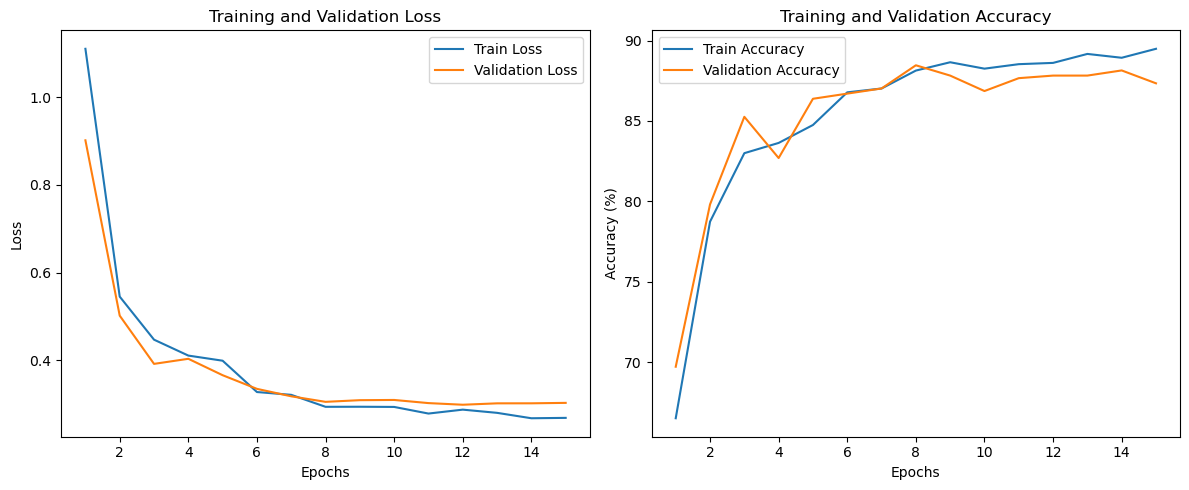

In [24]:
trainer.plot_metrics()

**Inference on Test Data**

In [25]:
real_labels, predicted_labels = trainer.test(test_loader)

Test Loss: 0.3630, Test Accuracy: 81.20%


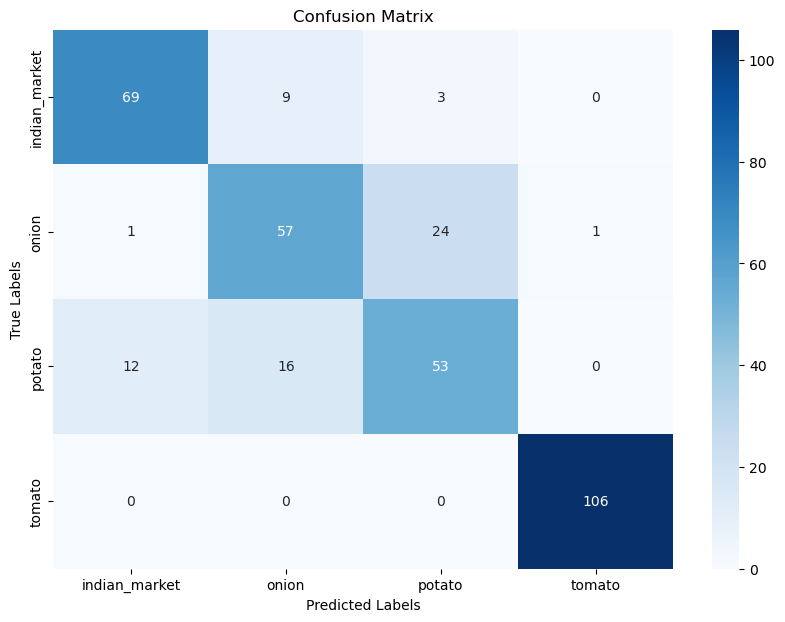

In [26]:
plt.figure(figsize=(10, 7))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(real_labels, predicted_labels),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plots, we can see that a CNN model with 4 convolution layers and 2 Linear layers has almost the same accuracy as the simple CNN model with 2 convolution layers.
- Further tuning of the model parameters may help improve the classification accuracy for these classes.

## Complex CNN with GAP

In [31]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pool=True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) if pool else None

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        if self.pool:
            x = self.pool(x)
        return x

class ComplexCNN_GAP(nn.Module):
    def __init__(self, num_classes=4):
        super(ComplexCNN_GAP, self).__init__()
        self.block1 = ConvBlock(3, 16)
        self.block2 = ConvBlock(16, 32)
        self.block3 = ConvBlock(32, 64)
        self.block4 = ConvBlock(64, 128)

        self.gap = nn.AdaptiveAvgPool2d((1, 1)) 

        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x
    

model = ComplexCNN_GAP(num_classes=4)
model.to(device) 
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
trainer = Trainer(model, optimizer, criterion, scheduler, checkpoint_path='../models/complex_cnn_gap.pth', patience=3)
trainer.train(train_loader, val_loader, num_epochs=20)

Epoch [1], Train Loss: 0.7629, Train Accuracy: 70.01%, Val Loss: 0.5393, Val Accuracy: 80.13%
Epoch [2], Train Loss: 0.5438, Train Accuracy: 79.09%, Val Loss: 0.5031, Val Accuracy: 78.37%
Epoch [3], Train Loss: 0.4661, Train Accuracy: 82.24%, Val Loss: 0.4167, Val Accuracy: 82.05%
Epoch [4], Train Loss: 0.4530, Train Accuracy: 82.16%, Val Loss: 1.0038, Val Accuracy: 69.39%
Epoch [5], Train Loss: 0.4264, Train Accuracy: 83.15%, Val Loss: 0.3863, Val Accuracy: 84.94%
Epoch [6], Train Loss: 0.3779, Train Accuracy: 84.91%, Val Loss: 0.3405, Val Accuracy: 86.54%
Epoch [7], Train Loss: 0.3551, Train Accuracy: 86.46%, Val Loss: 0.3380, Val Accuracy: 87.34%
Epoch [8], Train Loss: 0.3438, Train Accuracy: 86.46%, Val Loss: 0.3320, Val Accuracy: 87.02%
Epoch [9], Train Loss: 0.3440, Train Accuracy: 87.26%, Val Loss: 0.3333, Val Accuracy: 86.54%
Epoch [10], Train Loss: 0.3347, Train Accuracy: 86.70%, Val Loss: 0.3277, Val Accuracy: 87.02%
Epoch [11], Train Loss: 0.3394, Train Accuracy: 86.94%, Val

**Inference on Test Data**

In [33]:
real_labels, predicted_labels = trainer.test(test_loader)

Test Loss: 0.3862, Test Accuracy: 84.05%


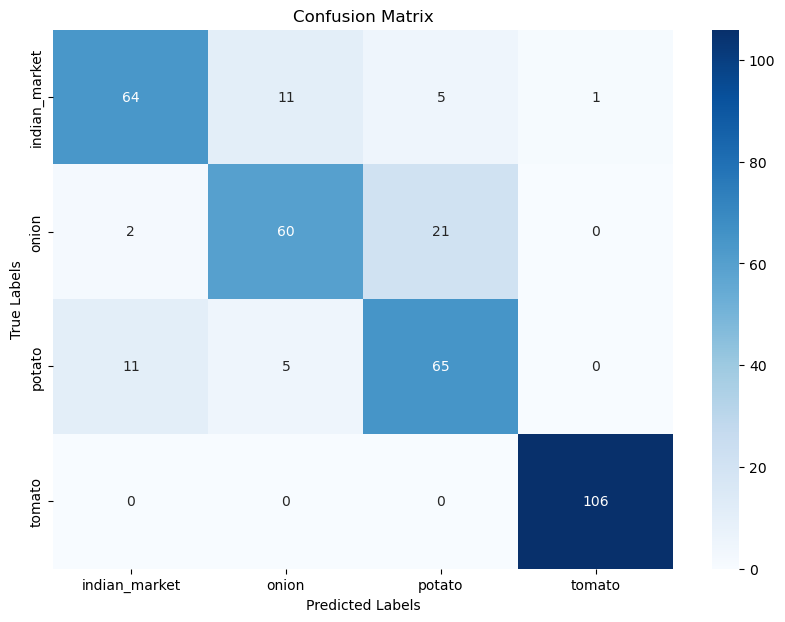

In [34]:
plt.figure(figsize=(10, 7))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(real_labels, predicted_labels),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print("F1 score: ", f1_score(real_labels, predicted_labels, average='weighted'), 
      "\nPrecision Score: ", precision_score(real_labels, predicted_labels, average='weighted'), 
      "\nRecall Score: ", recall_score(real_labels, predicted_labels, average='weighted'))

F1 score:  0.8404132200823867 
Precision Score:  0.8424999423523772 
Recall Score:  0.8404558404558404


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plots, we can see that a CNN model with 4 convolution layers and 2 Linear layers combined with Global Average Pooling (GAP) has better accuracy of 84.05% on the test set.
- This may be due to the fact that GAP reduces the number of parameters in the model and helps in better generalization.

## Resnet Transfer Learning

In [36]:
train_loader = torch.load('../data/processed/dataset/train_loader_resnet.pth', weights_only=False)
test_loader = torch.load('../data/processed/dataset/test_loader_resnet.pth', weights_only=False)
val_loader = torch.load('../data/processed/dataset/val_loader_resnet.pth', weights_only=False)

In [39]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet18, self).__init__()
        
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)
    
    
model = ResNet18(num_classes=4)
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
trainer = Trainer(model, optimizer, criterion, scheduler, checkpoint_path='../models/resnet_transfer_learning.pth', patience=3, log_dir='runs')
trainer.train(train_loader, val_loader, num_epochs=20)

Epoch [1], Train Loss: 0.8151, Train Accuracy: 68.54%, Val Loss: 0.5124, Val Accuracy: 83.01%
Epoch [2], Train Loss: 0.4672, Train Accuracy: 83.43%, Val Loss: 0.4096, Val Accuracy: 85.10%
Epoch [3], Train Loss: 0.4361, Train Accuracy: 84.55%, Val Loss: 0.3991, Val Accuracy: 85.74%
Epoch [4], Train Loss: 0.4296, Train Accuracy: 83.27%, Val Loss: 0.3603, Val Accuracy: 86.06%
Epoch [5], Train Loss: 0.3714, Train Accuracy: 87.06%, Val Loss: 0.3491, Val Accuracy: 86.70%
Epoch [6], Train Loss: 0.3444, Train Accuracy: 87.69%, Val Loss: 0.3451, Val Accuracy: 87.34%
Epoch [7], Train Loss: 0.3650, Train Accuracy: 86.38%, Val Loss: 0.3385, Val Accuracy: 87.18%
Epoch [8], Train Loss: 0.3644, Train Accuracy: 86.46%, Val Loss: 0.3392, Val Accuracy: 87.18%
Epoch [9], Train Loss: 0.3602, Train Accuracy: 86.78%, Val Loss: 0.3308, Val Accuracy: 87.18%
Epoch [10], Train Loss: 0.3480, Train Accuracy: 86.06%, Val Loss: 0.3405, Val Accuracy: 87.34%
Epoch [11], Train Loss: 0.3514, Train Accuracy: 85.98%, Val

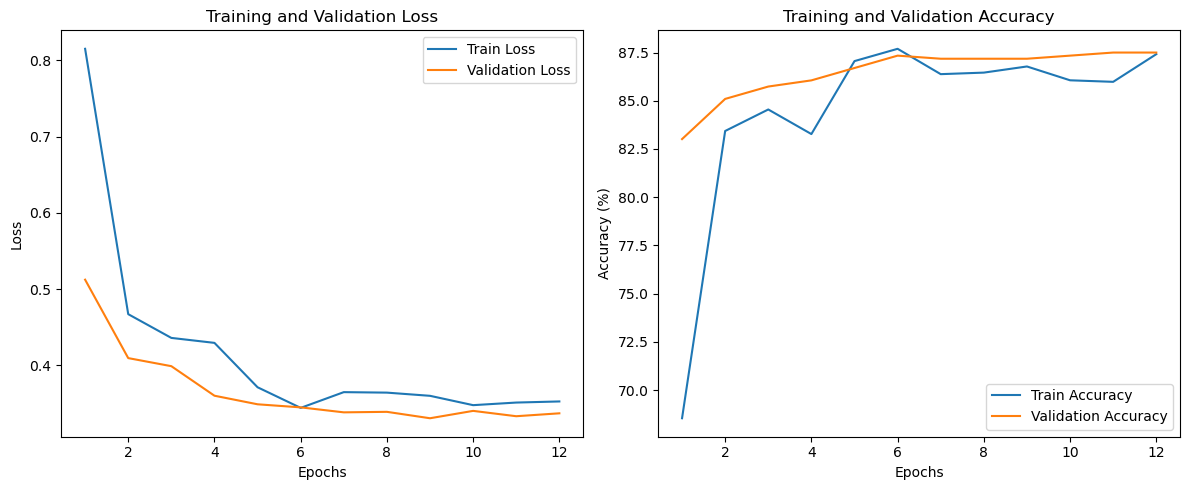

In [43]:
trainer.plot_metrics()

**Inference on Test Data**

In [41]:
real_labels, predicted_labels = trainer.test(test_loader)

Test Loss: 0.3410, Test Accuracy: 89.17%


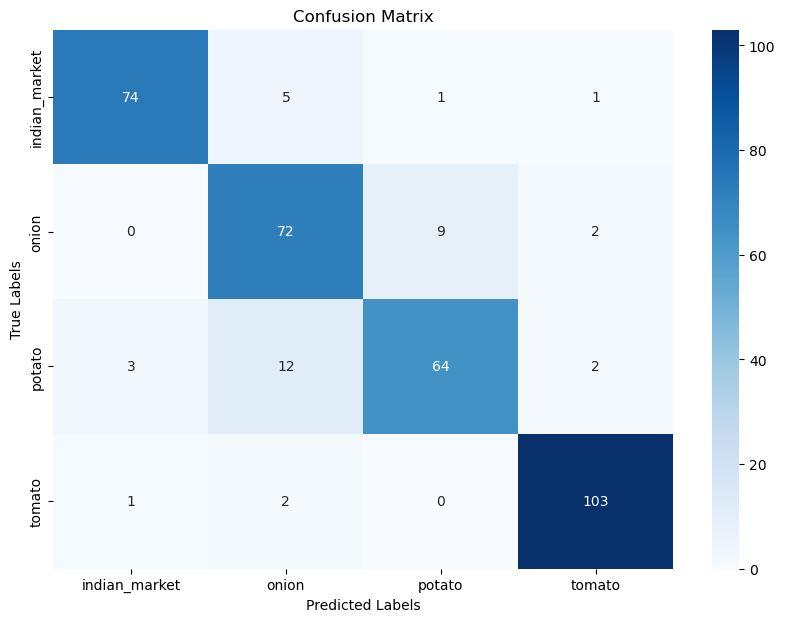

In [42]:
plt.figure(figsize=(10, 7))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(real_labels, predicted_labels),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [45]:
print("F1 score: ", f1_score(real_labels, predicted_labels, average='weighted'), 
      "\nPrecision Score: ", precision_score(real_labels, predicted_labels, average='weighted'), 
      "\nRecall Score: ", recall_score(real_labels, predicted_labels, average='weighted'))

F1 score:  0.8917766021245681 
Precision Score:  0.8936271514619093 
Recall Score:  0.8917378917378918


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plots, we can see that a Resnet model with transfer learning has the best accuracy of 8917% on the test set.
- This may be due to the fact that Resnet is a very deep model with skip connections that helps in better feature extraction and classification.
- The model is able to classify all the classes with a good accuracy but is still confused between Onion and Potato.

# Summary & Insights

**Dataset Insights**

The dataset used to train contains 3135 images, split into four folders as follows:  
- Tomato : 789
- Potato : 898
- Onion : 849
- Indian market : 599

The test dataset contains a total of 351 images, split into four folders:  
- Tomato : 106
- potato : 83
- onion : 81
- Indian market : 81

**Image Size**

- Most of the images are around 300x300 pixels.
- Most images are under 1000x1000 pixels.
- Potato has the highest number of images
- There does not seem to be any class imbalance in the dataset


**Model Performance**

<table>
  <thead>
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Simple CNN</td>
      <td>80.34%</td>
    </tr>
    <tr>
      <td>Complex CNN</td>
      <td>82.34%</td>
    </tr>
    <tr>
      <td>Complex CNN with GAP</td>
      <td>84.05%</td>
    </tr>
    <tr>
      <td>Resnet Transfer Learning</td>
      <td>89.17%</td>
    </tr>
  </tbody>
</table>



- From the above table, we can see that the Resnet model with transfer learning has the best accuracy of 89.17% on the test set.
- This may be due to the fact that Resnet is a very deep model with skip connections that helps in better feature extraction and classification.